In [56]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp
import random
from cvxpylayers.torch import CvxpyLayer

In [57]:
def followers_prob(mu, Q, V, ub):
    # n: number of assets
    # mu: expected returns (nx1)
    # Q: expected covariance (nxn)
    # V: maximum variance
    # ub: upper bound (nx1) 
    n = len(mu)
    x = cp.Variable(n)
    obj = cp.Maximize(mu.T @ x)
    const = [cp.quad_form(x, Q) <= V,
                np.ones([1, n]) @ x == 1,
                x >= 0,
                x <= ub]
    prob = cp.Problem(obj, const)

    prob.solve(solver=cp.ECOS)
    y = np.array([z if z > 1e-4 else 0 for z in x.value])
    print(f"max profit: {y}")

    return y

In [58]:
def get_lower_upper_var(Q, ub):
    # returns (L, U) for the variance to make it feasible
    K = 0.01 # increase chance of feasibility

    U = -float("inf")

    for index, val in enumerate(ub):
        if val and Q[index][index] > U:
            U = Q[index][index]

    n = len(Q)
    x = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(x, Q))
    const = [np.ones([1, n]) @ x == 1,
            x >= 0,
            x <= ub]
    
    prob = cp.Problem(obj, const)
    prob.solve(solver=cp.ECOS)
    print(f"min variance: {x.value}")
    L = prob.value*(1+K)

    return L, U

In [59]:
def plot_portfolios(portfolio):
    trader = {0: "Financials", 1: "Information Technology", 2: "Consumer Staples"}
    plt.subplots(nrows=1, ncols=4,figsize=(25, 5))

    all_tickers = []
    all_weights = []

    # plot each trader's distribution
    for i in portfolio:
        ax = plt.subplot(1, 4, i+1)
        plt.pie(portfolio[i].values(), labels=portfolio[i].keys())
        ax.set_title(f"{trader[i]} Trader Distribution")

        all_tickers.extend(portfolio[i].values())
        all_weights.extend(portfolio[i].keys())

    # plot the total firm distribution
    ax = plt.subplot(1, 4, 4)
    plt.pie(all_tickers, labels=all_weights)
    ax.set_title(f"Firm Distribution")

In [60]:
full_prices = pd.read_csv("../data/Equity_Prices_Full.csv", index_col=0)
full_prices.index = pd.to_datetime(full_prices.index)

sectors = {"Financials": ["ALL", "BAC", "C", "GS", "JPM"],
           "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
           "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]}

tickers = np.ndarray.flatten(np.array(list(sectors.values())))
n = len(tickers)

full_prices = full_prices[tickers]

In [61]:
strategies = {} #key is trader ID, value is ub array (1 if allowed to invest)

strategies[0] = [1 if ticker in sectors["Financials"] else 0 for ticker in tickers]
strategies[1] = [1 if ticker in sectors["Information Technology"] else 0 for ticker in tickers]
strategies[2] = [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in tickers]

In [66]:
subset_start_date = "2010-01-01"
subset_date = "2012-12-31"

subset_prices = full_prices.loc[subset_start_date:subset_date]
subset_returns = subset_prices.pct_change(1).iloc[1:, :]

training_returns = subset_returns.iloc[:-1,:]
test_returns = subset_returns.iloc[-1,:]

subset_prices.head()

,ALL,BAC,C,GS,JPM,AAPL,INTC,MSFT,IBM,CSCO,KO,COST,PG,WMT,TGT
Date,,,,,,,,,,,,,,,
2010-01-31,29.93,15.18,3.32,148.72,38.94,192.063,19.40,28.1800,122.39,22.47,54.25,57.43,61.55,53.43,51.27
2010-02-28,31.25,16.66,3.40,156.35,41.97,204.620,20.53,28.6700,127.16,24.33,52.72,60.97,63.28,54.07,51.52
2010-03-31,32.31,17.85,4.05,170.63,44.70,235.000,22.29,29.2875,128.25,26.03,55.00,59.71,63.27,55.60,52.60
2010-04-30,32.67,17.83,4.37,145.20,42.58,261.090,22.84,30.5350,129.00,26.93,53.45,59.08,62.16,53.64,56.87
2010-05-31,30.63,15.74,3.96,144.26,39.58,256.880,21.42,25.8000,125.26,23.16,51.40,58.25,61.09,50.56,54.53


In [68]:
mu = gmean(training_returns + 1) -1
Q = np.cov(training_returns.T)

assert mu.shape == (n,)
assert Q.shape == (n,n)

# check for PSD
assert min(np.linalg.eigvals(Q) > 1e-9)

AssertionError: 

min variance: [9.06460737e-01 3.08162951e-09 9.94222116e-03 8.35970139e-02
 2.45166969e-08 5.29946589e-14 5.51970673e-14 4.31208335e-14
 7.32507472e-14 1.81376490e-14 1.12405260e-13 6.43396590e-14
 7.74791220e-14 7.29596174e-14 6.36848106e-14]
max profit: [0.96749308 0.         0.01123153 0.02127512 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
min variance: [ 1.62444320e-14  2.96015748e-15 -2.94333076e-14 -1.75164312e-15
 -3.11743588e-15  4.34059146e-02  2.90866598e-08  9.08194939e-03
  9.47512100e-01  6.55408684e-09  2.08121979e-14  1.64923977e-14
  2.55069161e-14  2.02636411e-14  2.42947796e-14]
max profit: [0.         0.         0.         0.         0.         0.11714377
 0.         0.         0.88285399 0.         0.         0.
 0.         0.         0.        ]
min variance: [-5.62244815e-14 -5.94214294e-14  6.06328849e-14 -6.05220292e-14
 -6.75017499e-14 -4.67152519e-14 -5.46262249e-14 -5.45971143e-14
 -3.48776725e-1

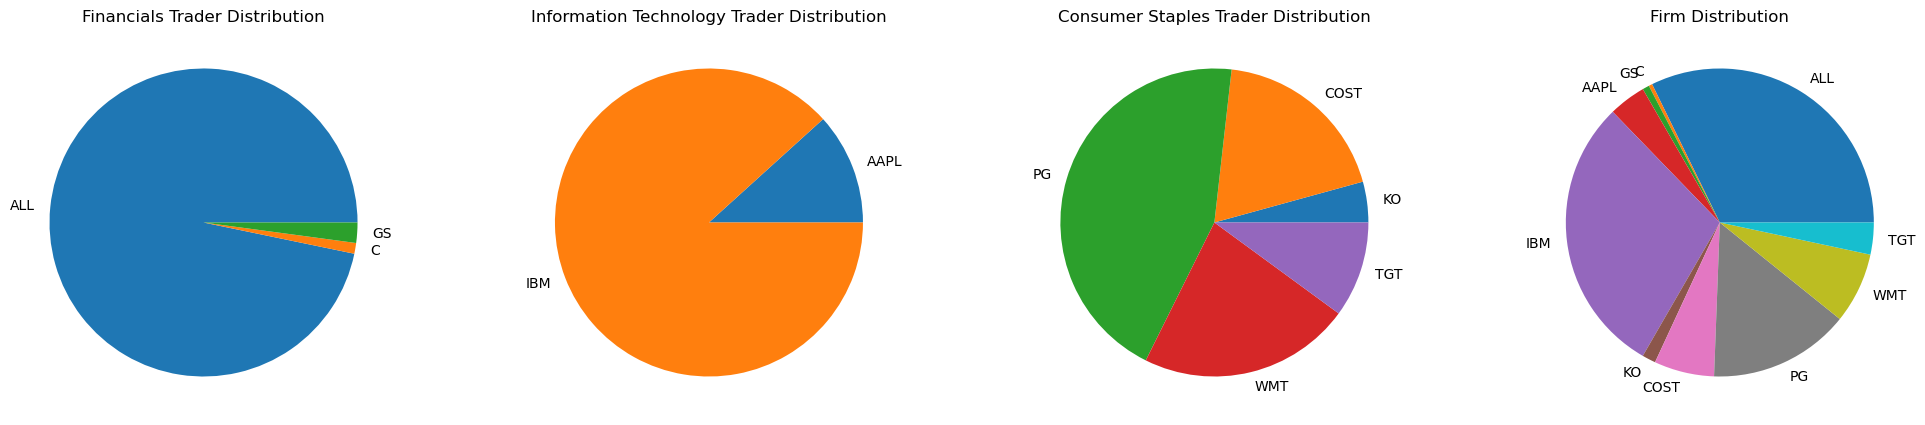

In [64]:
B = np.array([333, 333, 333])
overall_holdings = np.zeros(n)
total = 0

portfolio = {}

for i in range(3):
    L, U = get_lower_upper_var(Q, strategies[i])
    V = random.uniform(L, U)
    x = followers_prob(mu, Q, L, strategies[i])

    portfolio[i] = {tickers[index]:weight for index, weight in enumerate(x) if weight}
    overall_holdings += (B[i]*x)

reward = mu.T @ overall_holdings
risk = (overall_holdings @ Q @ overall_holdings)/(sum(B)**2)

print(f"Reward: {reward}")
print(f"Risk: {risk}")

plot_portfolios(portfolio)